# ML Classifier Copies - Image Segmentation Model Example

An example where we take an existing "black box" classifier model of the publicly available [Image Segmentation dataset](https://archive-beta.ics.uci.edu/ml/datasets/Image+Segmentation), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.evaluations import multivariable_density_comparison, keep_top_classes
from presc.copies.sampling import reduce_feature_space, uniform_sampling, normal_sampling, labeling

from ML_copies_original_models import SegmentationModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

We load a "black box" classifier model that we can query for the labels of any points.

In [4]:
segmentation_model = SegmentationModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [5]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression(max_iter=1000))])
knn_normal_classifier = Pipeline([('scaler', StandardScaler()), ('KKN_classifier', 
                                KNeighborsClassifier(n_neighbors=30, weights="distance"))])
tree_normal_classifier = DecisionTreeClassifier()

In [6]:
feature_description = segmentation_model.feature_description

In [7]:
balance_parameters={"max_iter": 50, "nbatch": 10000, "verbose": False}
log_normal_copy = ClassifierCopy(segmentation_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=20000, random_state=42,
                                 feature_parameters=feature_description, label_col="class",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

knn_normal_copy = ClassifierCopy(segmentation_model.model, knn_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=20000, random_state=42,
                                  feature_parameters=feature_description, label_col="class",
                                  **balance_parameters) 
knn_normal_copy_training_data = knn_normal_copy.copy_classifier(get_training_data=True)

tree_normal_copy = ClassifierCopy(segmentation_model.model, tree_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=20000, random_state=42,
                                 feature_parameters=feature_description, label_col="class",
                                 **balance_parameters) 
tree_normal_copy_training_data = tree_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [8]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * KNN copy:")
synthetic_knn_normal_test_data = knn_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_knn_normal_copy = knn_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_knn_normal_test_data)

print("\n * Decision tree copy:")
synthetic_tree_normal_test_data = tree_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_tree_normal_copy = tree_normal_copy.evaluation_summary(test_data=Dataset(
                                                segmentation_model.X_test.join(segmentation_model.y_test), label_col="class"), 
                                                                  synthetic_data=synthetic_tree_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.7524
Empirical Fidelity Error (synthetic)    0.2380
Empirical Fidelity Error (test)         0.2298
Replacement Capability (synthetic)      0.7620
Replacement Capability (test)           0.7920

 * KNN copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.7179
Empirical Fidelity Error (synthetic)    0.2950
Empirical Fidelity Error (test)         0.2738
Replacement Capability (synthetic)      0.7050
Replacement Capability (test)           0.7556

 * Decision tree copy:
Original Model Accuracy (test)          0.9500
Copy Model Accuracy (test)              0.6310
Empirical Fidelity Error (synthetic)    0.4440
Empirical Fidelity Error (test)         0.3500
Replacement Capability (synthetic)      0.5560
Replacement Capability (test)           0.6642


#### Conclusions
* All copies have a much worse accuracy than the original model, have a high emprical fidelity error, and a low replacement capability with this amount of synthetic training samples.
* However, the Decision Tree classifier is a particularly bad copy by all metrics.
* Of the three copies, the logistic regression is the one performing better.

[Index](#Index)  
  
  


<a name="Densities">  


### Summary of class density projections for the original classifier

Dissimilarity between the class density projections of the original classifier and those of the classifier copies is an indication of poor fidelity. Data used for the visualizations here is all synthetic.

The data points for the visualization of the original classifier and copies topologies must be sampled homogeneously throughout the feature space to avoid introducing spurious shapes in the projected density distributions. **uniform_sampling** is a good option for that.

**grid_sampling** is not recommended because it samples the specific interval points and displays density peaks.

In [9]:
# Segmentation class colors
colors = {"CEMENT":"#929a9b", "FOLIAGE":"#07c4b2", "WINDOW":"#ffcd1c", "PATH":"#6f5ed3", "BRICKFACE":"#db3e3e", 
          "GRASS":"#59cb59", "SKY":"#3896e3"}

In [10]:
# Reduce feature space to increase sampling efficiency with the uniform_sampling
reduced_feature_space = reduce_feature_space(feature_description, sigmas=2)

In [11]:
# We construct a number of data points and label them with the different classifiers
visualization_data = uniform_sampling(nsamples=10000, feature_parameters=reduced_feature_space)

visualization_original = labeling(visualization_data, segmentation_model.model, label_col="class")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="class")
visualization_knn = labeling(visualization_data, knn_normal_copy.copy, label_col="class")
visualization_tree = labeling(visualization_data, tree_normal_copy.copy, label_col="class")

In [12]:
reduced_visualization_original = keep_top_classes(visualization_original, min_num_samples=4)
reduced_visualization_log = keep_top_classes(visualization_log, min_num_samples=4)
reduced_visualization_knn = keep_top_classes(visualization_knn, min_num_samples=4)
reduced_visualization_tree = keep_top_classes(visualization_tree, min_num_samples=4)

The summary of the class densities for all the pairwise feature space projections allows to choose which are the most interesting plots in order to compare the class density of the projection for the different classifiers.

Since there are too many features, we only plot the summary of the class density projections for the Original Classifier, and splitting the features in two groups. Hence, only half of the projections are represented (the crossed projections between both groups of features are not represented).

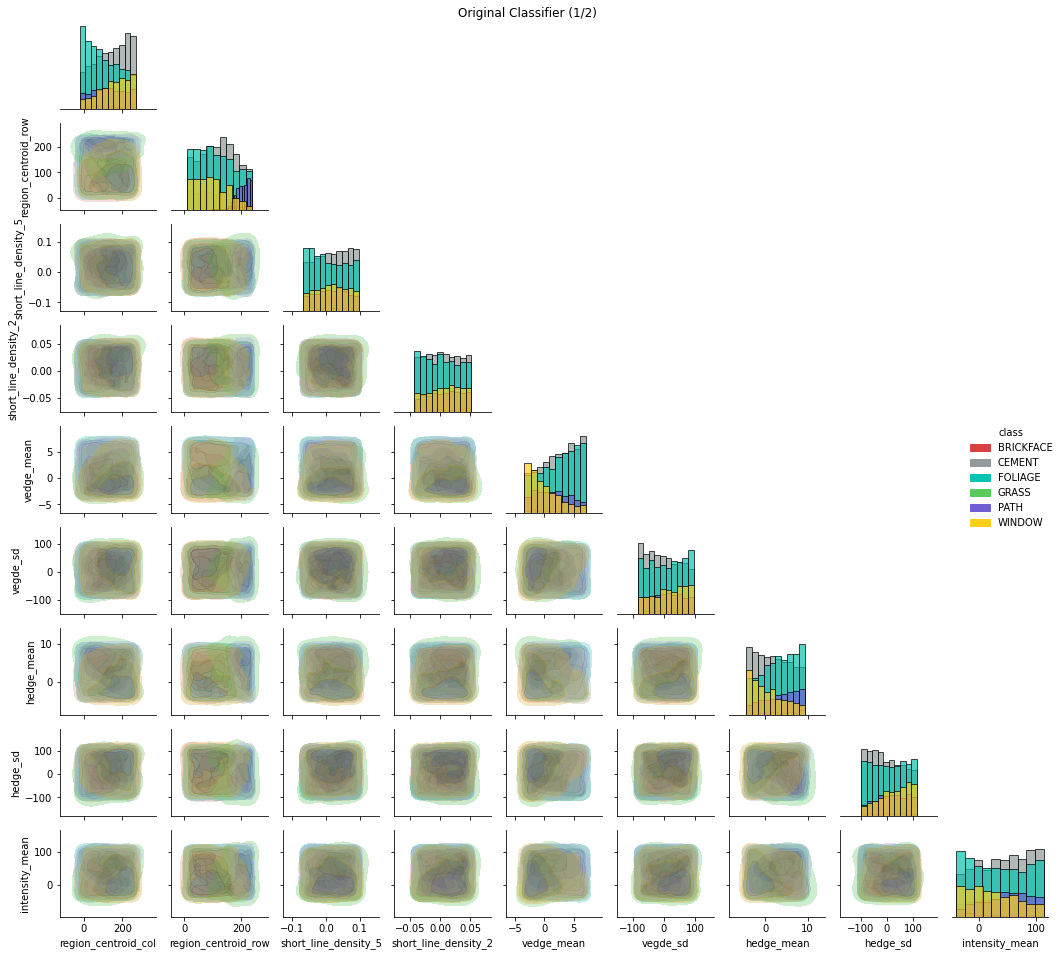

In [13]:
g = sns.PairGrid(pd.concat([reduced_visualization_original.df.iloc[:,:9], 
                            reduced_visualization_original.df["class"]], axis=1), 
                 hue="class", palette=colors, corner=True, height=1.5,
                 vars=[var_name for var_name in reduced_visualization_original.feature_names[:9]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Original Classifier (1/2)')
plt.tight_layout()
plt.show()

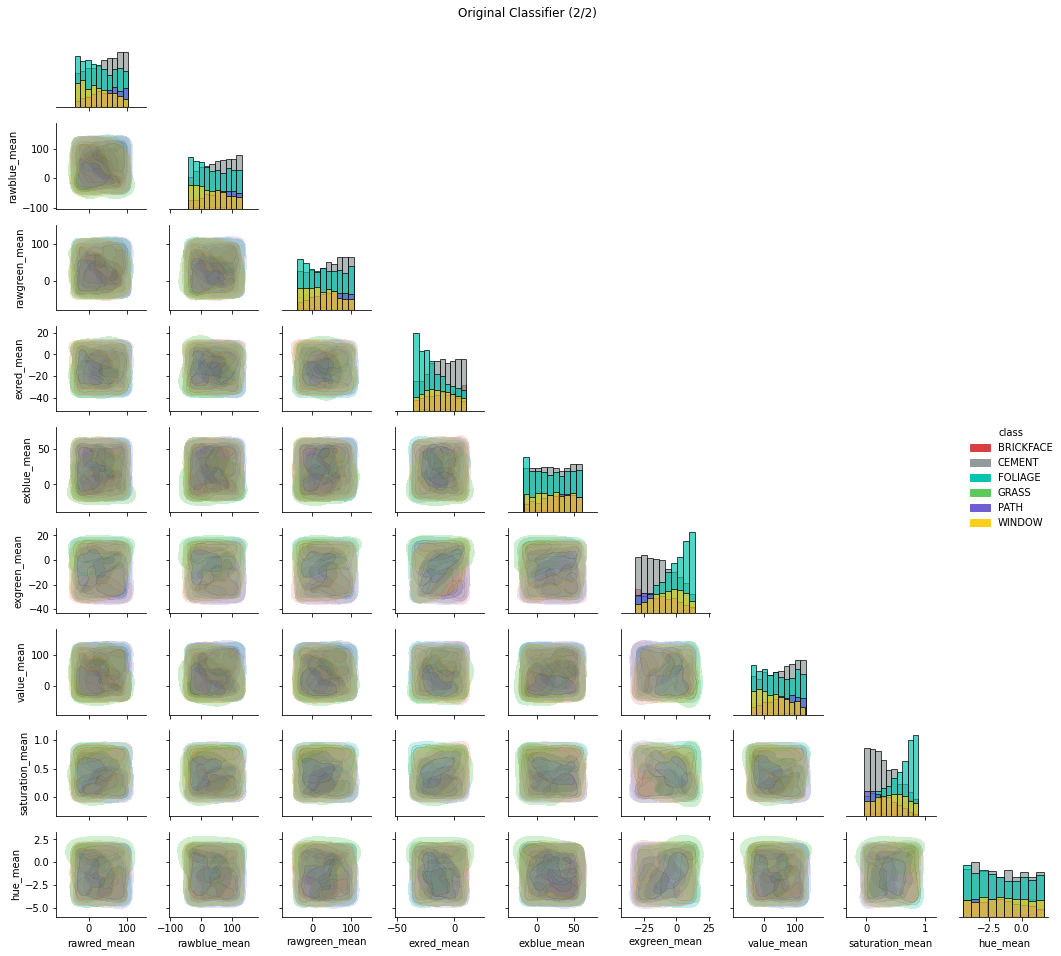

In [14]:
g = sns.PairGrid(reduced_visualization_original.df.iloc[:,9:], 
                 hue="class", palette=colors, corner=True, height=1.5,
                 vars=[var_name for var_name in reduced_visualization_original.feature_names[9:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Original Classifier (2/2)')
plt.tight_layout()
plt.show()

<a name="Densities">  


### Examples of detailed class density projections for each classifier

Here we have chosen a couple of parameters at a time and display their class densities side by side in detail for all the classifiers.

In [15]:
# We construct a number of data points and label them with the different classifiers
visualization_data = uniform_sampling(nsamples=50000, feature_parameters=reduced_feature_space)

visualization_original = labeling(visualization_data, segmentation_model.model, label_col="class")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="class")
visualization_knn = labeling(visualization_data, knn_normal_copy.copy, label_col="class")
visualization_tree = labeling(visualization_data, tree_normal_copy.copy, label_col="class")

In [16]:
reduced_visualization_original = keep_top_classes(visualization_original, min_num_samples=4)
reduced_visualization_log = keep_top_classes(visualization_log, min_num_samples=4)
reduced_visualization_knn = keep_top_classes(visualization_knn, min_num_samples=4)
reduced_visualization_tree = keep_top_classes(visualization_tree, min_num_samples=4)

In [17]:
# Common parameters
titles = ["Original Classifier", 
          "Logistic Regression Classifier Copy", "KNN Classifier Copy", "Decision Tree Classifier Copy"]
datasets = [reduced_visualization_original.df, reduced_visualization_log.df, 
            reduced_visualization_knn.df, reduced_visualization_tree.df]
other_kwargs = {"palette": colors}

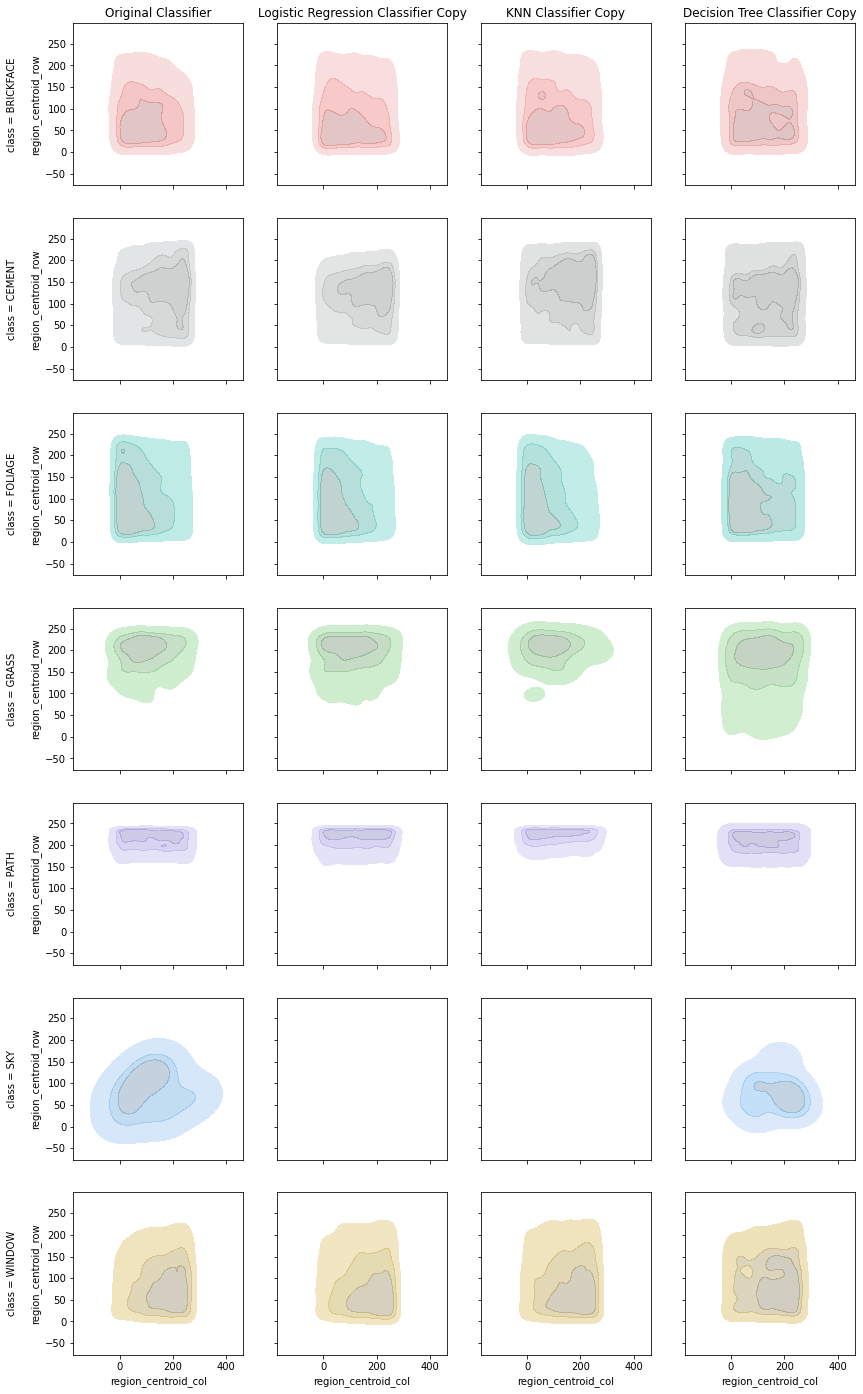

In [18]:
%%capture --no-display
feature1 = "region_centroid_col"
feature2 = "region_centroid_row"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="class", titles=titles, other_kwargs=other_kwargs)

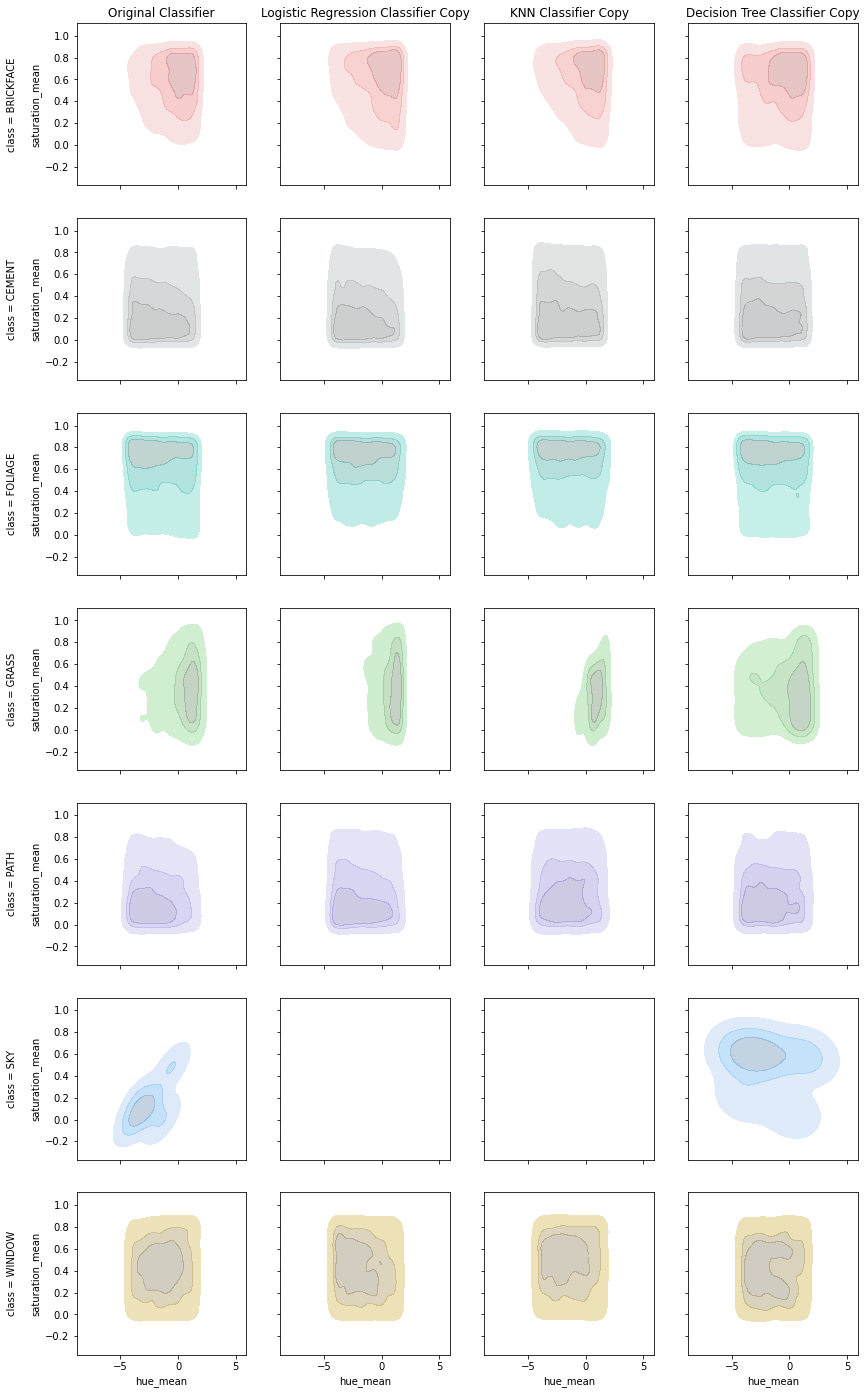

In [19]:
%%capture --no-display
feature1 = "hue_mean"
feature2 = "saturation_mean"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="class", titles=titles, other_kwargs=other_kwargs)

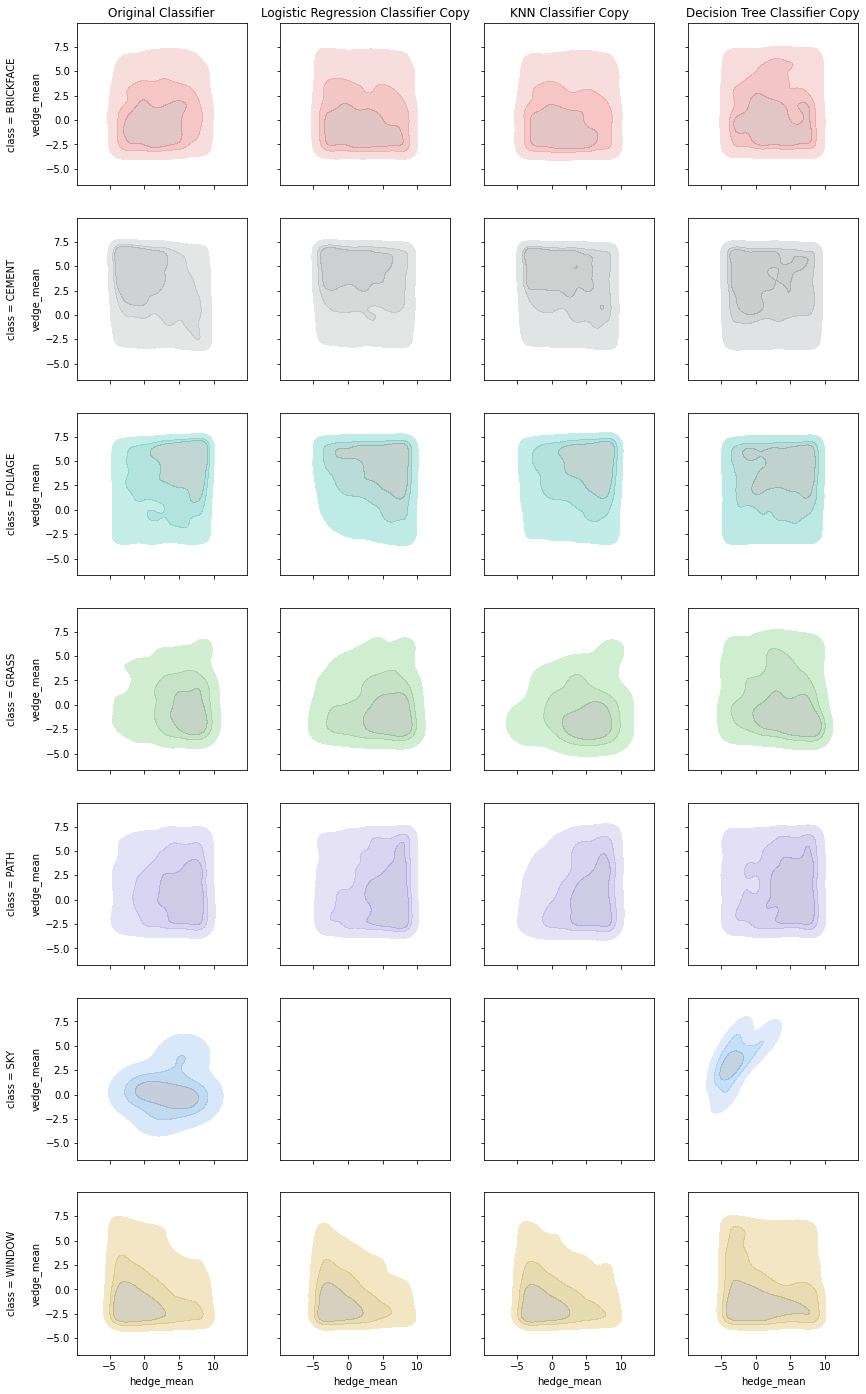

In [20]:
%%capture --no-display
feature1 = "hedge_mean"
feature2 = "vedge_mean"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="class", titles=titles, other_kwargs=other_kwargs)

#### Conclusions
* The topologies of class distributions from minoritary classes which were drawn using a very small number of samples are not reliable.

[Index](#Index)  
  
  

-----
-----